### S_in reduce 10% per run, 5 repeats for each reduction

0.0009
Grid dimensions: 512 x 512
Rung parameters at: DeltaSin = 10, Repeat = 5
 Activated Compute Device: Intel(R) Xeon(R) CPU E5-1650 v2 @ 3.50GHz

Progress :


FloatProgress(value=0.0, max=25.0)

 Simulation took      : 3902.6 (s)


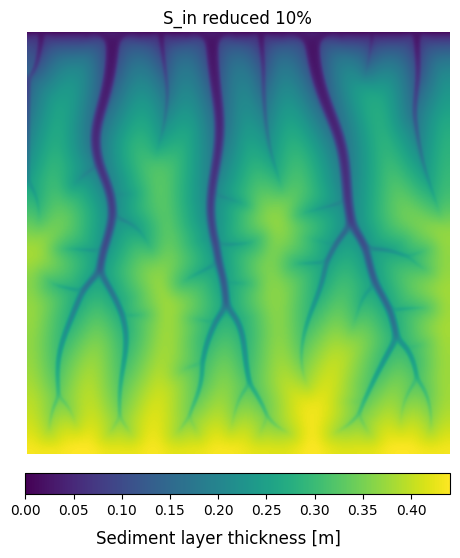

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import time,os
%matplotlib inline
on=1;off=0

############################################################################################
# Parameter definition
############################################################################################
# Hydrodynamic parameters
H0       = 0.02    # 0.02 [m] Imposed initial water layer thickness (equals the homogeneous equilibrium state)
g        = 9.8     # 9.8  [m/s^2] Gravitational acceleration constant
nn       = 0.05    # 5e-2 [s m^(-1/3)] Gauckler-Manning friction coefficient (Chow, 1959); (Mariotti and Fagherazzi, 2012 JGR) => n=0.016
HCrit    = 0.001   # 1e-3 [m] Critical water layer thickness (is always retained) in wetting-drying algorithm
slope    = 0.000   # 2e-3 [m/m] Subsediment plane bed slope
DifU     = 0.05    # 1e-2 [m^2/s] Turbulent eddy viscosity
Hin      = 0.00003 # 1e-4/5e-5 [m] Rain

# Vegetation roughness parameters
Cb       = 20.0    # 20.0 Chezy roughness of the bed
Cd       = 2.0     # 2.0  Chezy friction coefficient for maximal vegetation density
Hv       = 0.5     # 0.5  Shoot length
kv       = 0.41    # 0.41 Von Karman constant
DifD     = 0.0001  # 1e-4 Lateral expansion of vegetation

# Sedimentation parameters
S_in     = 0.0010  # 1e-3 [m/s] Sediment input
E0       = 7.0     # 3e-2 [s-1] "Background" erosion rate.
pE       = 0.9     # 0.5 / 0.9 [-] Fraction by which sediment erosion is reduced if algae are at carrying capacity
D0       = 0.0001  # 5e-2 [m^2 s^-1] Sediment diffusivity in absence of algae
pD       = 1.0     # 0.0 - 1.0 [-] Fraction by which sediment diffusivity is reduced if algae are at carrying capacity

# Diatom growth & erosion parameters
rr       = 0.060   # 0.30  [1/s] Growth rate algae
kk       = 1.0     # 1.0   [g/m^2] Carrying capacity algae
Qq       = 0.5     # 0.031 [m] Value of water level where algae loss is (approximately) half max (higher Qq = lower overall loss rate)
Qs       = 0.006   # 0.3   [-] Fraction of initial (homogeneous) water layer thickness at which sedimentation rate is (approximately) half maximal
Ec       = 6.0     # 20.0  [-] Conversion factor from sediment erosion to algae loss
dc       = 1e-3    # Conversion factor from sediment to biomass diffusion

# Gradient 1 (D0)
Gradient_D0 = off
D0       = 1e-3     # 1e-1
D0min    = 1e-1     # 1e-1 [m^2 s^-1] In absence of algae, background sediment diffusivity varies spatially between D0min and D0max
D0max    = 1e-3     # 1e-1 #(1e-1/SPT=maximum!)  # [m^2 s^-1] In absence of algae, background sediment diffusivity varies spatially between D0min and D0max

# Gradient 2 (Hin)
Gradient_Hin = off
Hin      = 0.00003  # 3e-5 [m] Rain
HinMin   = 0.00001  # 1e-4 [m] Rain
HinMax   = 0.00010  # 1e-4 [m] Rain

# Gradient 3 (DifD)
Gradient_DifD = off
DifD     = 1e-4     # 1e-4  # Lateral expansion of vegetation
DifDmin  = 1e-6     # 1e-5
DifDmax  = 1e-1     # 1e-2

# Gradient 4 (pD)
Gradient_pD = off
pD       = 1.0      # 0.0 [-] Fraction by which sediment diffusivity is reduced when at carrying capacity
pDmin    = 1e-1     # 1e-5
pDmax    = 1e1      # 1e-2
pDcon    = 2.0      # Constant determines curvature of logarithmic pD-gradient

# Gradient 5 (Hv)
Gradient_Hv = off
Hv       = 5e-1     # Shoot length
Hvmin    = 1e-3     # 1e-5
Hvmax    = 1e0      # 1e-2

############################################################################################
# Simulation settings
############################################################################################
EndTime   = 2500    # 20      - total time
# EndTime   = 5000    # 20      - total time
NumFrames = 25     # 50      - Number of times the figure is updated
NumFrames2= 50
dT        = 0.005   # 0.0005  - time step

# Thread block size
Block_Size_X   = 16     # 16
Block_Size_Y   = 16     # 16
# Number of blocks
# I define the Block_Number_ensions of the matrix as product of two numbers
# Makes it easier to keep them a multiple of something (16, 32) when using CUDA
Block_Number_X = 128     # 128
Block_Number_Y = 128     # 128
LengthX        = 200.0  # 200.0  Size of the domain in physical dimensions
LengthY        = 200.0  # 200.0  Size of the domain in physical dimensions

for i in range(10,100,10):
    deltaSin = i
    for j in range(1,6):
        repeat = j

        ############################################################################################
        # Redefine the S_in
        ############################################################################################
        S_in     = 0.0010  # 1e-3 [m/s] Sediment input
        S_in     = S_in*(100.0-deltaSin)/100.0
        print(S_in)
        
        print('Grid dimensions: %d x %d' % (Block_Size_X*Block_Number_X,Block_Size_Y*Block_Number_Y))
        print('Rung parameters at: DeltaSin = %d, Repeat = %d' % (i, repeat))
        # Derived simulation parameters 
        Grid_Width  = (Block_Size_X*Block_Number_X)     # Matrix A width
        Grid_Height = (Block_Size_Y*Block_Number_Y)     # Matrix A height
        
        dX = LengthX/Grid_Width   # space step
        dY = LengthY/Grid_Height   # space step
        
        # Precomputation
        h_homo = H0
        u_homo = np.sqrt(slope)*h_homo**(2.0/3.0)/nn # Balance between downslope acceleration and friction
        # v_homo      0                                   # No cross-slope flow in the homogeneous case
        # uabs_homo   sqrt((float)(u_homo*u_homo + v_homo*v_homo))
        # uabsMax     uabs_homo    # Maximal absolute flow speed (equal to uabs in the homogeneous equilibrium)
        # D_homo      kk*(1.0f-double(Ec*E0*(Qd+h_homo)/(Qq+h_homo))/double(rr))
        s_homo = S_in*u_homo*u_homo*(H0-HCrit)/(Qs+(H0-HCrit))/E0
        # S_homo      S_in/E0

        ############################################################################################
        # 在s_homo之前和之后改变Sin会有什么不一样？
        ############################################################################################
        
        X, Y = np.meshgrid(np.linspace(0,1,Grid_Width), np.linspace(0,1,Grid_Height))
        
        np.random.seed(10)
        u = np.zeros((Grid_Width*Grid_Height)) + u_homo
        v = np.zeros((Grid_Width*Grid_Height)) + 0.0
        h = np.zeros((Grid_Width*Grid_Height)) + h_homo
        b = np.zeros((Grid_Width*Grid_Height)) + (1.0-X.flatten())*slope*LengthX;
        s = np.zeros((Grid_Width*Grid_Height)) + s_homo
        d = (np.random.rand(Grid_Width*Grid_Height) < 0.002) * 1.0 + 0.0
        
        u_host = u.astype(np.float32)
        v_host = v.astype(np.float32)
        h_host = h.astype(np.float32)
        b_host = b.astype(np.float32)
        s_host = s.astype(np.float32)
        d_host = d.astype(np.float32)
        
        ############################################################################################
        # Setting up the Graphics Card Unit (GPU) for OpenCL use
        ############################################################################################
        import pyopencl as cl
        import platform as pl
        
        # Defining the device that is used
        if pl.system()=='Darwin':
            DeviceNr = 0   # 0 = CPU; 1 = Intel; 2 = AMD 
        else:
            DeviceNr = 0   # 0 = CPU; 1 = Intel; 2 = AMD
        
        os.environ['PYOPENCL_COMPILER_OUTPUT'] = '2'
        
        platform = cl.get_platforms()
        Devices  = platform[0].get_devices()
        context  = cl.Context([Devices[DeviceNr]])
        queue    = cl.CommandQueue(context)
        
        print(" Activated Compute Device: %s\n" % Devices[DeviceNr].name)
        
        mf = cl.mem_flags # Memory flags are set
        
        # The array is allocated on the GPU and the initial values are copied onto it
        u_g = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=u_host)
        v_g = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=v_host)
        h_g = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=h_host)
        b_g = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=b_host)
        s_g = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=s_host)
        d_g = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=d_host)
        
        # Set up simulation parameters
        global_size=u_host.shape
        local_size=(Block_Number_X*Block_Number_Y,)
        
        # List of parameters for the OpenCL kernel. Seperate with comma without spaces
        # Setting up the parameters for the Kernel
        
        '''PassVars="H0,g,nn,HCrit,slope,DifU,Hin,Cb,Cd,Hv,kv,DifD,S_in,E0,pE,D0,pD," + \
                 "rr,kk,Qq,Qs,Ec,dc," + \
                 "D0min,D0max,HinMin,HinMax,DifDmin,DifDmax,pDmin,pDmax,Hvmin,Hvmax," + \
                 "Gradient_D0,Gradient_Hin,Gradient_DifD,Gradient_pD,Gradient_Hv"'''
        PassVars="dT,Grid_Width,Grid_Height,dX,dY," + \
                 "H0,g,nn,HCrit,slope,DifU,Hin,Cb,Cd,Hv,kv,DifD,S_in,E0,pE,D0,pD,rr,kk,Qq,Qs,Ec,dc," + \
                 "D0min,D0max,HinMin,HinMax,DifDmin,DifDmax,pDmin,pDmax,Hvmin,Hvmax," + \
                 "Gradient_D0,Gradient_Hin,Gradient_DifD,Gradient_pD,Gradient_Hv"
        
        PassVals=eval(PassVars)
        PassVars=PassVars.split(',')
        Params=""
        
        for ii in range(len(PassVals)):
            Params = Params+"#define " + PassVars[ii] + " " + str(PassVals[ii]) + " \n"
        
        # Params    
        
        ############################################################################################
        # Computing kernel
        ############################################################################################
        ComputeCode = """
        
        float difco(float, float, size_t);
        float d2_dxy2_S(__global float*, __global float*);
        
        #define cl_max(A,B)	(A>B?A:B)
        #define cl_min(A,B)	(A<B?A:B)
        
        #define ON 1
        #define OFF 0
        
        float difco(float d1, float d2, size_t column)
        {
            float dm = (d1+d2)/2.0 ;
        
            #if Gradient_pD == ON
                    float pDx = exp( (float)(log((float)pDmax)-log((float)pDmin))*(float)column/(float)Grid_Width+log((float)pDmin) );
        //     Logarithmic pD-profile (because pD is in the exponent)
        //    float pDx = ((float)pDmax-(float)pDmin)/(float)pDcon*log((float)1.0+(exp((float)pDcon)-(float)1.0)*(float)column/(float)Grid_Width)+(float)pDmin ;
            #else
                // With constant biomass diffusion (until run21)
                float pDx = (float)pD;
                // With biomass diffusion a function of biomass itself (from run21 onwards)
                //        float DifDx = dc*d2_dxy2_S(d,d);
            #endif
        
            #if Gradient_D0 == ON
                float D0x = exp( (float)(log((float)D0max)-log((float)D0min))*(float)column/(float)Grid_Width+log((float)D0min) );
            #else
                float D0x = D0;
            #endif
        
            // From hi-res model
            // float ds = exp((float)-dm/(float)(pD*2));
            // float retval = D0*ds*ds ;
        
            float ds = exp((float)-dm*(float)pDx/(float)kk);
            float retval = D0x*ds;
            return retval;
        
        }
        
        float d2_dxy2_S(__global float* s, __global float* d)
        {
            const float dx = dX;
            const float dy = dY;
        
            const size_t current = get_global_id(0);
            const size_t row     = (size_t)current/(size_t)Grid_Width;
            const size_t column  = (size_t)current%(size_t)Grid_Width;
        
            const size_t  left=row * Grid_Width + column-1;
            const size_t  right=row * Grid_Width + column+1;
            const size_t  top=(row-1) * Grid_Width + column;
            const size_t  bottom=(row+1) * Grid_Width + column;
        
            return difco(d[right]  ,d[current], column)/dx/dx * (s[right]   - s[current]) -
                   difco(d[current],d[left]   , column)/dx/dx * (s[current] - s[left]) +
                   difco(d[bottom] ,d[current], column)/dy/dy * (s[bottom]  - s[current]) -
                   difco(d[current],d[top]    , column)/dy/dy * (s[current] - s[top]);
        
        //    return difco(d[right]  ,d[current])/dx/dx * (s[right]   - s[current]) -
        //           difco(d[current],d[left]   )/dx/dx * (s[current] - s[left]) +
        //           difco(d[bottom] ,d[current])/dy/dy * (s[bottom]  - s[current]) -
        //           difco(d[current],d[top]    )/dy/dy * (s[current] - s[top]);
        
        }
        
        ////////////////////////////////////////////////////////////////////////////////
        // Simulation kernel
        ////////////////////////////////////////////////////////////////////////////////
        
        __kernel void SimulationKernel (__global float* u,
                                        __global float* v,
                                        __global float* h,
                                        __global float* b,
                                        __global float* s,
                                        __global float* d)
        {
            // A-priori varaible definition
        
            float du, dv, dh, drh, ds;
        
            // Determining the position at which the current thread is computing
        
            const size_t current = get_global_id(0);
            const size_t row     = (size_t)current/(size_t)Grid_Width;
            const size_t column  = (size_t)current%(size_t)Grid_Width;
        
            #if Gradient_Hv == ON
                float Hvx = exp( (float)(log((float)Hvmax)-log((float)Hvmin))*(float)column/(float)Grid_Width+log((float)Hvmin) );
            #else
                float Hvx = Hv;
            #endif
        
            // --- Determining frication, and computing change in flow ----------------------
        
            // The net speed of the water
            float uabs     = sqrt(u[current]*u[current]+v[current]*v[current]);
        
            // A make-shift wetting-drying algoritm
            h[current]     = cl_max(h[current],HCrit);
        
            // Computing the Chezy coefficient, using the baptist equation
            float Dv       = 1.0*d[current];
        
            // Correct formulation of Ct (kappa and log outside sqrt), used from run1 onwards:
            float Ct       = sqrt( (float)(1.0/(1.0/(Cb*Cb)+1.0/(2.0*g)*Cd*Dv*Hvx)) )
            + sqrt((float)g)/(float)kv*log((float)cl_max(h[current]/Hvx,1.0));
        
            // Formulation below contains errors (kappa and log should not be inside sqrt) (used for comparison @ run0)
        //        float Ct       = sqrt( (float)(1.0/(1.0/(Cb*Cb)+1.0/(2.0*g)*Cd*Dv*Hv)) )
        //                              + sqrt( (float)(g/kv)*log((float)cl_max(h[current]/Hv,1.0)) );
        
            if(row > 0 && row < Grid_Height-1 && column > 0 && column < Grid_Width-1)
            {
                // Change in water velocity u in the X direction
                du = - g*(dO_dx(h,s,b))
                     - u[current]*d_dx(u)
                     - v[current]*d_dy(u)
                     - g/(Ct*Ct)*uabs*u[current]/h[current]
                     + DifU*d2_dxy2(u);
        
                // Change in water velocity v in the Y direction
                dv = - g*dO_dy(h,s,b)
                     - u[current]*d_dx(v)
                     - v[current]*d_dy(v)
                     - g/(Ct*Ct)*uabs*v[current]/h[current]
                     + DifU*d2_dxy2(v);
        
                // Updating water flow
                u[current] = u[current] + du*dT;
                v[current] = v[current] + dv*dT;
            }
        
            // --- Handle Flow at the Boundaries ---------------------------------------
            else if(row==0) // Right boundaries
            {
                u[row * Grid_Width + column] = 2*u[1 * Grid_Width + Grid_Width] - u[2 * Grid_Width + Grid_Width];
                v[row * Grid_Width + column] = 2*v[1 * Grid_Width + Grid_Width] - v[2 * Grid_Width + Grid_Width];
                //PersistentFluxBoundaries(u);
                //PersistentFluxBoundaries(v);
            }
            else
            {
                //NeumanBoundaries(u);   // Constant flow boundary
                //NeumanBoundaries(v);   // Constant flow boundary
                ReflectingBoundaries(u,v);
            }
        
            //barrier(CLK_GLOBAL_MEM_FENCE);
        
            // --- Remaining state variables are computed here -----------------------------
        
            if(row > 0 && row < Grid_Height-1 && column > 0 && column < Grid_Width-1)
            {
                // --- Continuity equation -------------------------------------------------
                dh = - d_uh_dx(u,h) - d_vh_dy(v,h);
        
                #if Gradient_Hin == ON
                    //float HinX= (HinMax-HinMin)*(float)column/(float)Grid_Width+HinMin;
                    float HinX = exp( (float)(log((float)HinMax)-log((float)HinMin))*(float)column/(float)Grid_Width+log((float)HinMin) );
                    drh = HinX;
                #else
                    drh = Hin;
                #endif
        
                // --- Sediment differential equation --------------------------------------
                float h_eff = h[current]-HCrit;
                // Formulation used from run7 onwards (erosion related to BSS)
                ds = S_in*h_eff/(Qs+h_eff)
                     - E0*(1-pE*d[current]/kk)*s[current]*uabs*uabs*(g/(Ct*Ct))
                     + d2_dxy2_S(s,d);
        
                // Formulation used until run6 (erosion quadratic with flow speed)
                // ds = S_in*h_eff/(Qs+h_eff)
                //      - E0*(1-pE*d[current]/kk)*s[current]*uabs*uabs
                //      + d2_dxy2_S(s,d);
        
                // --- Algal differential equation -----------------------------------------
        
                #if Gradient_DifD == ON
                    //float HinX= (HinMax-HinMin)*(float)column/(float)Grid_Width+HinMin;
                    float DifDx = exp( (float)(log((float)DifDmax)-log((float)DifDmin))*(float)column/(float)Grid_Width+log((float)DifDmin) );
                #else
                // With constant biomass diffusion (until run21)
                    float DifDx = DifD;
                // With biomass diffusion a function of biomass itself (from run21 onwards)
                // float DifDx = dc*d2_dxy2_S(d,d);
                #endif
        
                // Formulation used from run7 onwards (biomass loss related to BSS) until run 21
                float dD = rr*d[current]*(1 - d[current]/kk)*Qq/(Qq+h_eff) - Ec*d[current]*uabs*uabs*(g/(Ct*Ct)) + DifDx*d2_dxy2(d) ;
        
                // Updating water level, sediment height, and algal density
                float Phi = 1.0;    //0.25 // Morfological acceleration factor (1s = phi*1tide)
        
                h[current] = h[current] + dT*(dh+drh);
                s[current] = s[current] + dT*ds*Phi;
                d[current] = d[current] + dT*dD*Phi;
        
            }
        
            // --- Handle Boundaries for h, s, and d ---------------------------------------
            else if(row==0) // Right boundaries
            {
                NeumanBoundaries(h);   // No height gradient
                s[current] = 0;        // Fixed sediment height boundary
                NeumanBoundaries(d);
            }
            else
            {
                NeumanBoundaries(h);   // No height gradient
                NeumanBoundaries(s);   // Zero flux in s
                NeumanBoundaries(d);   // Zero flux in d
                //DirichletBoundaries(d,0.5);   // Fixed values (1) for d
            }
        
        } // End SimulationKernel   
        
        """
        
        ############################################################################################
        # Load Laplace Operator and Neumann boundaries
        ############################################################################################
        with open('HydroFunctions_iPy.cl', 'r') as myfile:
           SpatialFunctions = myfile.read()
        
        ############################################################################################
        # Compile the kernel
        ############################################################################################
        program = cl.Program(context, Params + SpatialFunctions + ComputeCode).build()
        
        ############################################################################################
        # The main simulation loop
        ############################################################################################
        from ipywidgets import FloatProgress
        from IPython.display import display
        
        # Setting up a progress bar for the simulation
        print("Progress :");
        PB = FloatProgress(min=0, max=NumFrames); display(PB) 
        
        us = np.zeros((Grid_Height, Grid_Width, NumFrames))
        vs = np.zeros((Grid_Height, Grid_Width, NumFrames))
        hs = np.zeros((Grid_Height, Grid_Width, NumFrames))
        bs = np.zeros((Grid_Height, Grid_Width, NumFrames))
        ss = np.zeros((Grid_Height, Grid_Width, NumFrames))
        ds = np.zeros((Grid_Height, Grid_Width, NumFrames))
        ts = np.zeros((Grid_Height, Grid_Width, NumFrames)) # tau
        
        start_time = time.time() # Starting a timer:
        
        # Starting the loop
        for count in range(NumFrames):
        
            # The simulation is executed here for EndTime/dT/NumFrames times
            for jj in range(int(EndTime/dT/NumFrames)):
                program.SimulationKernel(queue, global_size, None, u_g, v_g, h_g, b_g, s_g, d_g)
        
            # Get the data from the GPU
            cl.enqueue_copy(queue, u_host, u_g)
            cl.enqueue_copy(queue, v_host, v_g)
            cl.enqueue_copy(queue, h_host, h_g)
            cl.enqueue_copy(queue, b_host, b_g)
            cl.enqueue_copy(queue, s_host, s_g)
            cl.enqueue_copy(queue, d_host, d_g)
        
        
            # We store the state of the system for <NumPlot> different times.
            us[:,:,count] = u_host.reshape(Grid_Height,Grid_Width) # water flow in u direction
            vs[:,:,count] = v_host.reshape(Grid_Height,Grid_Width) # water flow in v direction
            hs[:,:,count] = h_host.reshape(Grid_Height,Grid_Width) # water level
            bs[:,:,count] = b_host.reshape(Grid_Height,Grid_Width) # bed 
            ss[:,:,count] = s_host.reshape(Grid_Height,Grid_Width) # sediment elevation
            ds[:,:,count] = d_host.reshape(Grid_Height,Grid_Width) # vegetation biomass
        
            hmax1 = hs[:,:,count];
            hmax2 = hs[:,:,count];
            for hhi in range(hmax1.shape[0]):
                for hhj in range(hmax1.shape[1]):
                    hmax2[hhi,hhj] = max(hmax1[hhi,hhj]/Hv,1.0)
            CT = np.sqrt( (1.0/(1.0/(Cb*Cb)+1.0/(2.0*g)*Cd*ds[:,:,count]*Hv)) ) + np.sqrt(g)/kv*np.log(hmax2); # Chezy coefficient [m^(1/2) s^-1] (Baptist formulation)
            rho = 1000; # Water density [kg/m3]
            NetSpeed=np.sqrt(us[:,:,count]**2+vs[:,:,count]**2)
            ts[:,:,count] = rho*NetSpeed*NetSpeed*(g/(CT*CT)); # Bed shear stress [Pa]
        
            PB.value += 1 # signal to increment the progress bar
        
        print(" Simulation took      : %1.1f (s)" % (time.time() - start_time))
        
        # ############################################################################################
        # # Redefine the Hin
        # ############################################################################################
        # Hin      = 0.00003  # 3e-5 [m] Rain
        # Hin       = Hin*(100.0-deltaSin)/100.0
        # print(Hin)
        
        # List of parameters for the OpenCL kernel. Seperate with comma without spaces
        # Setting up the parameters for the Kernel
        
        # '''PassVars="H0,g,nn,HCrit,slope,DifU,Hin,Cb,Cd,Hv,kv,DifD,S_in,E0,pE,D0,pD," + \
        #          "rr,kk,Qq,Qs,Ec,dc," + \
        #          "D0min,D0max,HinMin,HinMax,DifDmin,DifDmax,pDmin,pDmax,Hvmin,Hvmax," + \
        #          "Gradient_D0,Gradient_Hin,Gradient_DifD,Gradient_pD,Gradient_Hv"'''
        # PassVars="dT,Grid_Width,Grid_Height,dX,dY," + \
        #          "H0,g,nn,HCrit,slope,DifU,Hin,Cb,Cd,Hv,kv,DifD,S_in,E0,pE,D0,pD,rr,kk,Qq,Qs,Ec,dc," + \
        #          "D0min,D0max,HinMin,HinMax,DifDmin,DifDmax,pDmin,pDmax,Hvmin,Hvmax," + \
        #          "Gradient_D0,Gradient_Hin,Gradient_DifD,Gradient_pD,Gradient_Hv"
        
        # PassVals=eval(PassVars)
        # PassVars=PassVars.split(',')
        # Params=""
        
        # for ii in range(len(PassVals)):
        #     Params = Params+"#define " + PassVars[ii] + " " + str(PassVals[ii]) + " \n"
        # # Params   
        
        # # Reinitializing the data arrays and giving them stable state value
        # program = cl.Program(context, Params + SpatialFunctions + ComputeCode).build()
        
        # from ipywidgets import FloatProgress
        # from IPython.display import display
        
        # # Setting up a progress bar for the simulation
        # print("Progress :");
        # PB = FloatProgress(min=0, max=NumFrames); display(PB) 
        
        # start_time = time.time() # Starting a timer:
        
        # # Starting the loop
        # for count in range(NumFrames,NumFrames2):
        
        #     # The simulation is executed here for EndTime/dT/NumFrames times
        #     for jj in range(int(EndTime/dT/NumFrames)):
        #         program.SimulationKernel(queue, global_size, None, u_g, v_g, h_g, b_g, s_g, d_g)
        
        #     # Get the data from the GPU
        #     cl.enqueue_copy(queue, u_host, u_g)
        #     cl.enqueue_copy(queue, v_host, v_g)
        #     cl.enqueue_copy(queue, h_host, h_g)
        #     cl.enqueue_copy(queue, b_host, b_g)
        #     cl.enqueue_copy(queue, s_host, s_g)
        #     cl.enqueue_copy(queue, d_host, d_g)
        
        
        #     # We store the state of the system for <NumPlot> different times.
        #     us[:,:,count] = u_host.reshape(Grid_Height,Grid_Width) # water flow in u direction
        #     vs[:,:,count] = v_host.reshape(Grid_Height,Grid_Width) # water flow in v direction
        #     hs[:,:,count] = h_host.reshape(Grid_Height,Grid_Width) # water level
        #     bs[:,:,count] = b_host.reshape(Grid_Height,Grid_Width) # bed 
        #     ss[:,:,count] = s_host.reshape(Grid_Height,Grid_Width) # sediment elevation
        #     ds[:,:,count] = d_host.reshape(Grid_Height,Grid_Width) # vegetation biomass
        
        #     hmax1 = hs[:,:,count];
        #     hmax2 = hs[:,:,count];
        #     for hhi in range(hmax1.shape[0]):
        #         for hhj in range(hmax1.shape[1]):
        #             hmax2[hhi,hhj] = max(hmax1[hhi,hhj]/Hv,1.0)
        #     CT = np.sqrt( (1.0/(1.0/(Cb*Cb)+1.0/(2.0*g)*Cd*ds[:,:,count]*Hv)) ) + np.sqrt(g)/kv*np.log(hmax2); # Chezy coefficient [m^(1/2) s^-1] (Baptist formulation)
        #     rho = 1000; # Water density [kg/m3]
        #     NetSpeed=np.sqrt(us[:,:,count]**2+vs[:,:,count]**2)
        #     ts[:,:,count] = rho*NetSpeed*NetSpeed*(g/(CT*CT)); # Bed shear stress [Pa]
        
        #     PB.value += 1 # signal to increment the progress bar
        
        # print(" Simulation took      : %1.1f (s)" % (time.time() - start_time))

        # np.savez('Root/HinReduce_'+format(deltaSin)+'_'+format(repeat)+'_AllData.npz',
        #          u=us[:,:,:],
        #          v=vs[:,:,:],
        #          h=hs[:,:,:],
        #          b=bs[:,:,:],
        #          s=ss[:,:,:],
        #          d=ds[:,:,:],
        #          EndTime=EndTime,
        #          NumFrames=NumFrames)

        np.savez('Root/HinReduce_'+format(deltaSin)+'_'+format(repeat)+'_LastStep.npz',
                 u=us[:,:,NumFrames-1],
                 v=vs[:,:,NumFrames-1],
                 h=hs[:,:,NumFrames-1],
                 b=bs[:,:,NumFrames-1],
                 s=ss[:,:,NumFrames-1],
                 d=ds[:,:,NumFrames-1],
                 EndTime=EndTime,
                 NumFrames=NumFrames)

        fs = 12
        fig, ax = plt.subplots(figsize=(6, 6))

        im1=ax.imshow(ss[:,:,NumFrames-1], animated=True) #, interpolation='bilinear')
        ax.set_title('S_in reduced '+format(deltaSin)+'%', fontsize=fs)
        ax.set_axis_off()
        f=fig.colorbar(im1, ax=ax, fraction=0.046, pad=0.04, orientation='horizontal')

        text2=fig.suptitle('Sediment layer thickness [m]', x=0.48, y=0.05);

        fig.savefig('Root/SinReduce_'+format(deltaSin)+'_'+format(repeat)+'.jpg',dpi = 500)
        
import os
os.system('say "your script has finished"')